In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
df = pd.read_parquet('/content/drive/MyDrive/BA820 Project/Dataset/merged_data1.parquet')
print(df.head())

                 user_id                 name_x           time  rating  \
0  116404531305033742641  Zygintas Krasodomskis  1568240961087     5.0   
1  101806853201406057266            Olga Harbar  1590701094969     3.0   
2  110623621391484838669             Amit Patel  1558575636156     4.0   
3  114893265310260912873         Jerry Cardillo  1535435901765     4.0   
4  106080008682473967828           Jake Moreira  1487952273508     4.0   

                                                text  resp  \
0                     Honestly, best burgers in town  None   
1                                               None  None   
2                                               None  None   
3                                               None  None   
4  This place gave me a good sanwich and a fry bu...  None   

                                 gmap_id                 name_y  \
0  0x89e37a19e56a4565:0xbb2aefc495e8c505              Five Guys   
1  0x89e45acc1861f709:0x9ccc502a907ff195  Price 

In [5]:
df.isnull().sum()

,0
user_id,0
name_x,0
time,0
rating,0
text,391626
resp,756452
gmap_id,0
name_y,0
address,0
latitude,0


In [6]:
df['text'] = df['text'].fillna("N/A")
df['resp'] = df['resp'].fillna("N/A")

In [7]:
df.isnull().sum()

,0
user_id,0
name_x,0
time,0
rating,0
text,0
resp,0
gmap_id,0
name_y,0
address,0
latitude,0


In [8]:
numerical_cols = ['rating', 'longitude', 'latitude', 'avg_rating', 'num_of_reviews']
categorical_cols = ['category']
text_cols = ['text', 'resp']

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_scaled = scaler.fit_transform(df[numerical_cols])

num_df = pd.DataFrame(num_scaled, columns=[f"num_feature_{i}" for i in range(num_scaled.shape[1])])


In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
category_encoded = mlb.fit_transform(df[categorical_cols])

# Convert to DataFrame with proper column names
category_df = pd.DataFrame(category_encoded, columns=mlb.classes_)

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_text = TfidfVectorizer(stop_words='english', max_features=50)
vectorizer_resp = TfidfVectorizer(stop_words='english', max_features=50)

text_transformed = vectorizer_text.fit_transform(df['text'])
resp_transformed = vectorizer_resp.fit_transform(df['resp'])

# Convert to DataFrame
text_df = pd.DataFrame(text_transformed.toarray(), columns=[f"text_{col}" for col in vectorizer_text.get_feature_names_out()])
resp_df = pd.DataFrame(resp_transformed.toarray(), columns=[f"resp_{col}" for col in vectorizer_resp.get_feature_names_out()])

HDBSCAN

In [14]:
import numpy as np
from pyproj import Transformer
from sklearn.cluster import DBSCAN

df_location = df[['longitude', 'latitude']]
df_sample = df_location.sample(frac=0.1, random_state=42)

transformer = Transformer.from_crs("EPSG:4326", "EPSG:32619", always_xy=True)
x_coords, y_coords = transformer.transform(
    df_sample['longitude'].values,  # longitude
    df_sample['latitude'].values   # latitude
)

coords_m = np.column_stack((x_coords, y_coords))

dbscan = DBSCAN(eps=10000, min_samples=300, metric='euclidean').fit(coords_m)
df_sample['cluster'] = dbscan.labels_

In [15]:
from sklearn.metrics import silhouette_score
import numpy as np

# Filter out noise points
mask = df_sample['cluster'] != -1
if len(np.unique(df_sample.loc[mask, 'cluster'])) > 1:
    score = silhouette_score(coords_m[mask], df_sample.loc[mask, 'cluster'])
    print("Silhouette Score:", score)
else:
    print("Not enough clusters for silhouette score calculation.")


Silhouette Score: 0.41745788245874016


In [16]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86149 entries, 76173 to 234383
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   longitude  86149 non-null  float64
 1   latitude   86149 non-null  float64
 2   cluster    86149 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.6 MB


In [17]:
!pip install cartopy


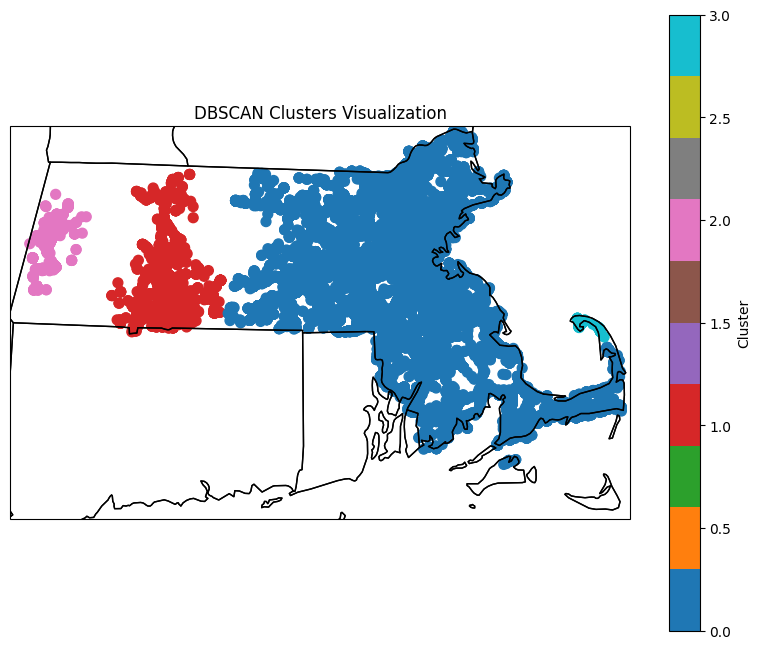

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

df_filtered = df_sample[df_sample['cluster'] != -1].copy()
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent([-73.5, -69.9, 41.2, 42.9], crs=ccrs.PlateCarree())

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, edgecolor='black')

scatter = ax.scatter(
    df_filtered['longitude'],
    df_filtered['latitude'],
    c=df_filtered['cluster'],
    cmap='tab10',
    s=50,
    transform=ccrs.PlateCarree()
)

plt.colorbar(scatter, ax=ax, label='Cluster')
plt.title('DBSCAN Clusters Visualization')
plt.show()


Massachusetts is characterized by a heavily populated eastern region, with Boston as the principal urban hub. Moving westward, the state transitions into more rural terrain, featuring rolling hills and smaller cities like Worcester and Springfield. Coastal areas, such as Cape Cod and the North Shore, attract significant tourism, reflecting a distinct seasonal population influx. Major highways (e.g., I-90 and I-495), which is really near the center of Providence RI, create transportation corridors that influence both economic activity and the spatial distribution of data points.